# CS235 Fall 2024 Course Project

Student 1 - Name: Ashok Kumar J (862467018)

Student 2 - Name: Dan Shay (862546326)


## Introduction
In this project, a number of data
mining techniques that we cover in this class will be implemented and applied to a real-world imbalanced
dataset.

**Dataset:** Wisconsin Breast Cancer Diagnostic dataset from the UCI data repository: https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic

In [61]:
!pip3 install ucimlrepo

In [87]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score
from sklearn.decomposition import TruncatedSVD
from math import sqrt, log, pi

from ucimlrepo import fetch_ucirepo
from collections import Counter

## Load Data

In [63]:
# Fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# Data (as pandas dataframes)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

# Metadata
print(breast_cancer_wisconsin_diagnostic.metadata)

# Convert 'M' to 1 and 'B' to 0 for binary classification
y = y['Diagnosis'].apply(lambda x: 1 if x == 'M' else 0).values  # Convert to a 1D numpy array of integers

X

{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


## Exploratory Data Analysis (EDA)

### Pairwise correlation between features

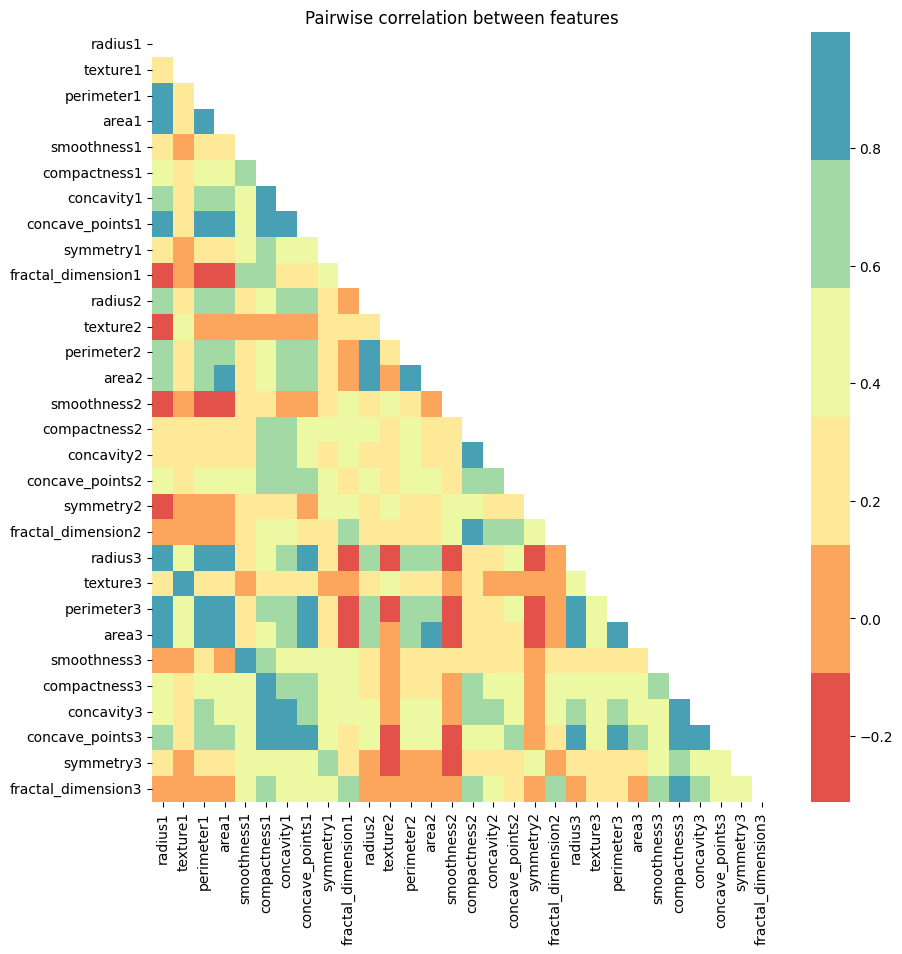

In [64]:
correlation = X.corr()

fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.heatmap(correlation, annot=False, mask=np.triu(correlation),
            cmap=sns.color_palette("Spectral"))
ax.set_title("Pairwise correlation between features")
plt.show()

### Class-wise counts

In [65]:
print(Counter(y))

Counter({0: 357, 1: 212})


### Class-wise features distributions

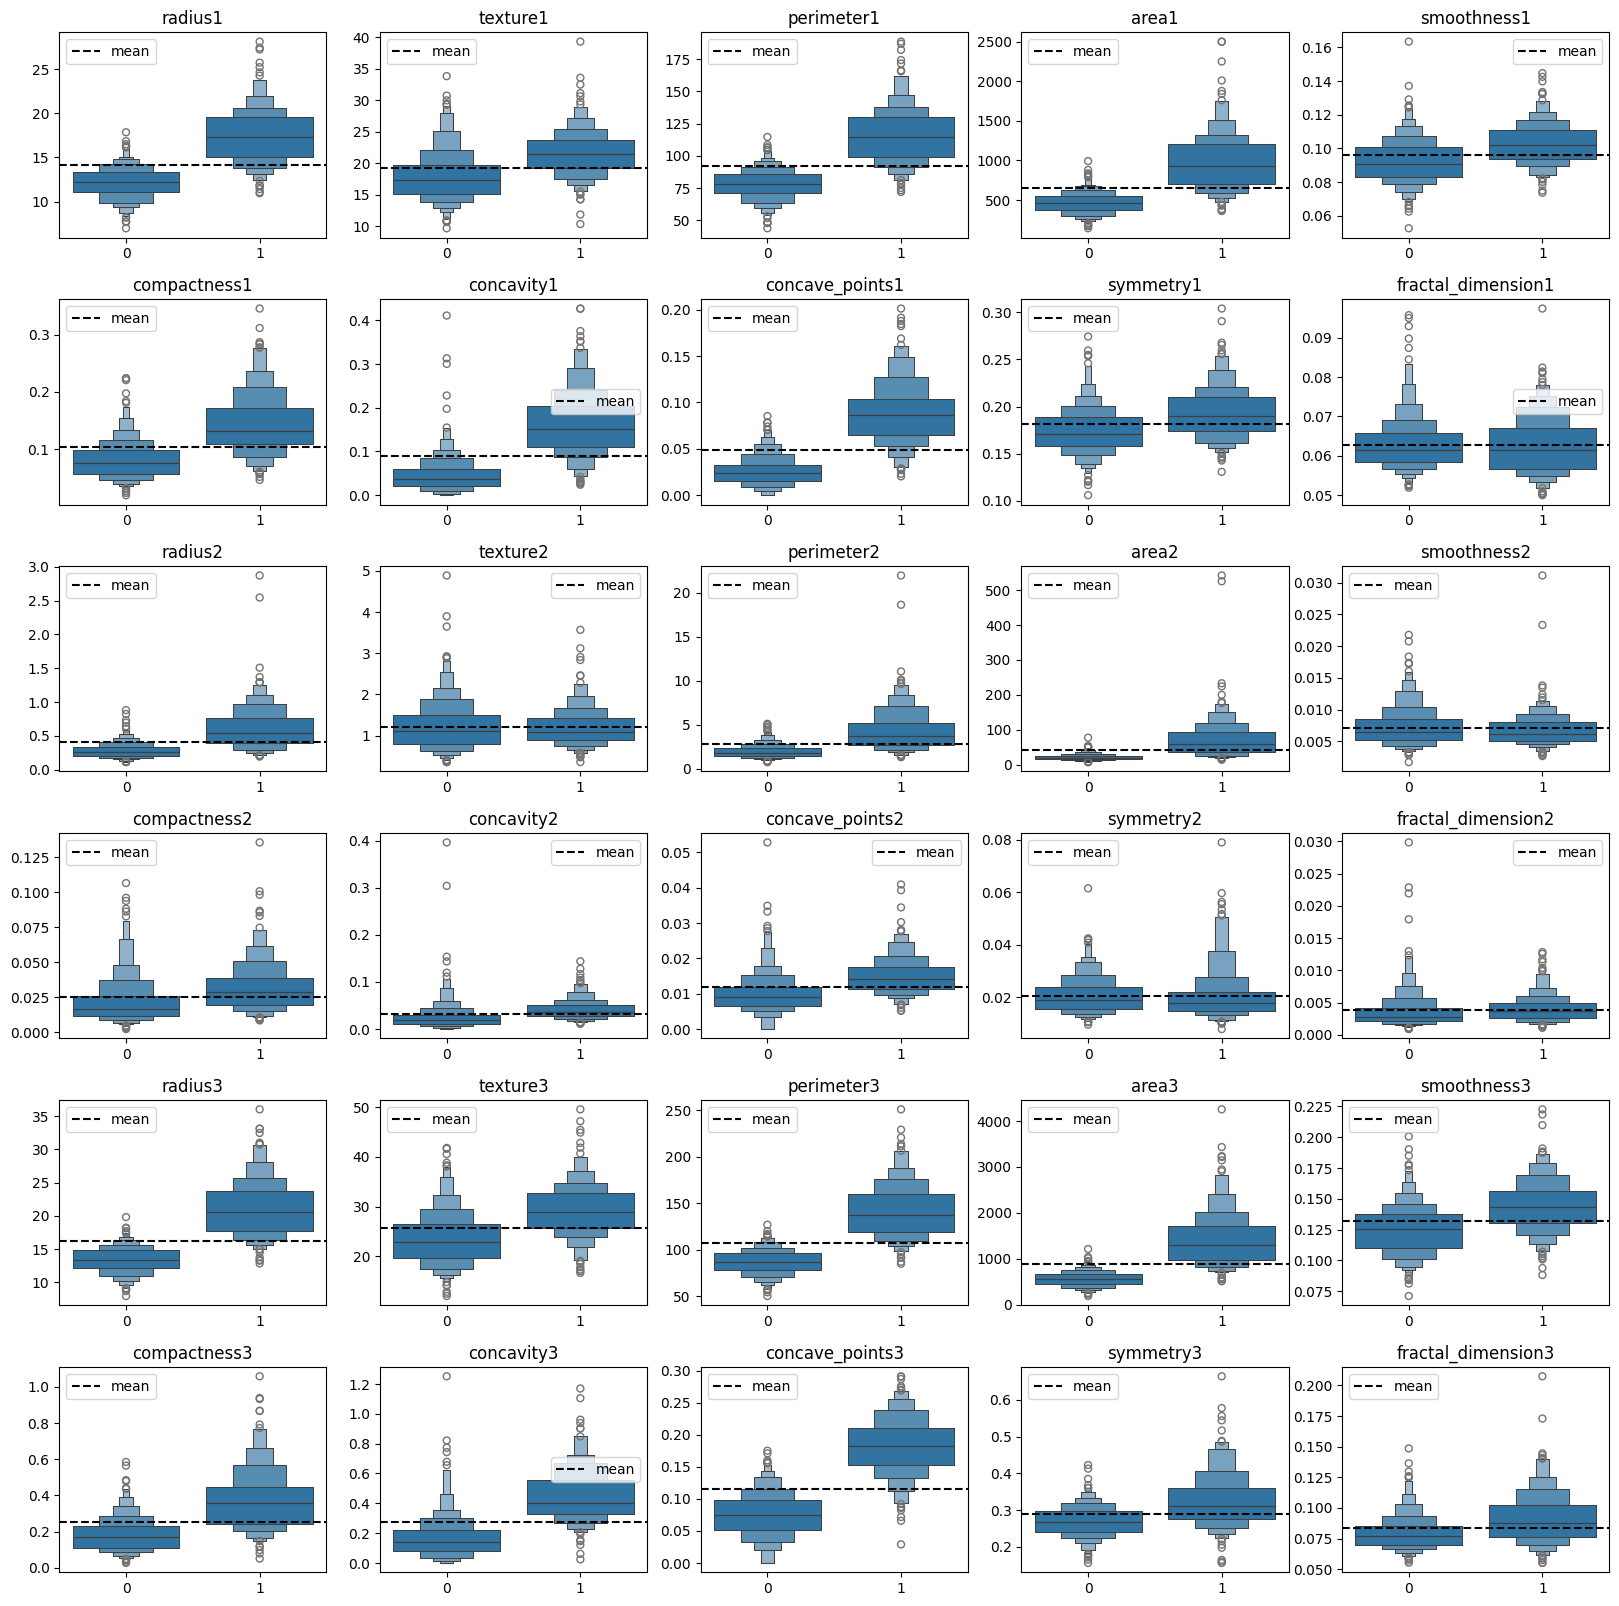

In [66]:
plt.figure(figsize=(20, 20))
for i, j in itertools.zip_longest(list(X.columns), range(len(list(X.columns)))):
    plt.subplot(6, 5, j + 1)
    sns.boxenplot(x=y, y=X[i])
    plt.title(i)
    plt.xlabel('')
    plt.ylabel('')
    plt.subplots_adjust(hspace=.3)
    plt.axhline(X[i].mean(), linestyle="dashed", color='k', label='mean')
    plt.legend(loc='best')

# Phase 1 - Supervised Techniques

## Q1 - Implementing simple classifiers

#### Steps followed
1. write code for Decision Tree and NaiveBayes from scratch, including all methods like entropy, information gain and probability density
2. Used stratified 10-fold cross-validation to evaluate the classifiers, reporting the mean and standard deviation of F1 scores for each model.
3. Generated a bar chart to compare the mean F1 scores of the Decision Tree and Naive Bayes classifiers.

In [ ]:
# Decision Tree Classifier
class DecisionTreeClassifier:
    def __init__(self, max_depth=None):
        """
        Params:
            max_depth (int): Maximum depth of the tree. If None, the tree will grow until pure or all leaves reached.
        """
        self.max_depth = max_depth

    def entropy(self, y):
        """
        Computes the entropy of given values

        Params:
            y (ndarray): Input label values
        
        Returns:
            entropy (float): Entropy of the given values
        
        """
        counts = np.bincount(y)
        # Calculate the ratio of the current label in y
        probabilities = counts / len(y)
        return -np.sum([p * log(p, 2) for p in probabilities if p > 0])

    def information_gain(self, y, left_y, right_y):
        """
        Computes info gain from splitting the paretn dataset into 2 datasets

        Parameters:
            y (ndarray): Input main dataset
            left_y, right_y (ndarray): Subset of the dataset after split

        Returns:
            information_gain (float): Information gain of the split
        """
        # info_gain is initially set to 0, but for better factoring of code, info_gain var is not used, the value is directly rreturned
        # compute entropy for parent
        parent_entropy = self.entropy(y)
        # calculate weight for left and right subsets
        left_weight = len(left_y) / len(y)
        right_weight = len(right_y) / len(y)
        # calculate and return info_gain
        return parent_entropy - (left_weight * self.entropy(left_y) + right_weight * self.entropy(right_y))

    def split(self, X, y, index, threshold):
        """
        Split dataset based on feature index and threshold

        Params:
            X (ndarray): Feature matrix
            y (ndarray): Labels array
            index (int): Feature index to split on
            thrreshold (flaot): Threshold value for splitting

        Returns:
            X_left, X_right, y_left, y_right (tuple of ndarrays): Split datasets based on the threshold.
        """
        left_mask = X[:, index] <= threshold
        right_mask = X[:, index] > threshold
        return X[left_mask], X[right_mask], y[left_mask], y[right_mask]

    def best_split(self, X, y):
        """
        Identifies best fetaure index and threshold to split the dataset

        Params:
            X (ndarray): Feature matrix
            y (ndarray): Labels array

        Returns:
            best_split (tuple): best feature index and threshold for splitting.
        """
        best_gain = -1 # init best gain at minimum
        best_split = None # init best split params
        n_features = X.shape[1] # number of features in dataset
        # iterate over all features
        for feature_index in range(n_features):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                X_left, X_right, y_left, y_right = self.split(X, y, feature_index, threshold)
                # only taking valid splits
                if len(y_left) > 0 and len(y_right) > 0:
                    gain = self.information_gain(y, y_left, y_right)
                    # update best split  if current gain is greater
                    if gain > best_gain:
                        best_gain = gain
                        best_split = (feature_index, threshold)
        return best_split

    def build_tree(self, X, y, depth=0):
        """
        Build the decision tree, based on the best split, unitl max depth is reached.

        Params:
            X (ndarray): Feature matrix
            y (ndarray): Labels array
            depth (int): current depth of the tree

        Returns:
            node: returns the most common class label or split info
        """
        # if max depth reached, or data is pure.  return most common label
        if self.max_depth is not None and depth >= self.max_depth:
            return Counter(y).most_common(1)[0][0]

        # find the best split
        split = self.best_split(X, y)
        if split is None:
            return Counter(y).most_common(1)[0][0]

        # get feature index and threshold of the best split
        feature_index, threshold = split
        X_left, X_right, y_left, y_right = self.split(X, y, feature_index, threshold)

        # recursively build left and right tree
        left_subtree = self.build_tree(X_left, y_left, depth + 1)
        right_subtree = self.build_tree(X_right, y_right, depth + 1)

        return (feature_index, threshold, left_subtree, right_subtree)

    def fit(self, X, y):
        self.tree = self.build_tree(np.array(X), np.array(y))

    def predict_sample(self, x, tree):
        """
        Predict the class labels for a single sample by travelling the tree.

        Params:
            x (ndarray): Feature values of a single sample
            tree: decision tree structure

        Returns:
            label (int): predicted class label for the sample
        """
        if not isinstance(tree, tuple):
            return tree

        feature_index, threshold, left_subtree, right_subtree = tree
        if x[feature_index] <= threshold:
            return self.predict_sample(x, left_subtree)
        else:
            return self.predict_sample(x, right_subtree)

    def predict(self, X):
        """
        Predict class labels for all samples

        Params:
            x (ndarray): Feature matrix for prediction

        Returns:
            prediction (list): list of predicted class labels
        """
        return [self.predict_sample(x, self.tree) for x in np.array(X)]

In [ ]:
class NaiveBayesClassifier:
    def __init__(self):
        self.class_stats = {}

    def fit(self, X, y):
        """
        Trains the Naive Bayes classifier by computing mean, variance, and prior probabilities for each class.
        
        Parameters:
            X (ndarray): Feature matrix.
            y (ndarray): Labels array.
        """
        # Convert X to a NumPy array if it's not already
        X = np.asarray(X)
        for cls in np.unique(y):
            # Extract samples belonging to class 'cls'
            cls_X = X[y == cls]
            # Compute mean and variance along each feature dimension
            mean = cls_X.mean(axis=0)
            var = cls_X.var(axis=0) + 1e-6  # Adding epsilon for numerical stability
            # Store the stats for each class
            self.class_stats[cls] = {'mean': mean, 'var': var}
        
        # Calculate class priors (probability of each class)
        self.class_priors = {cls: np.mean(y == cls) for cls in np.unique(y)}

    def gaussian_pdf(self, x, mean, var):
        """
        Computes the Gaussian Probability Density Function for a given feature value.
        
        Parameters:
            x (float): Feature value.
            mean (float): Mean of the feature for a class.
            var (float): Variance of the feature for a class.
        
        Returns:
            pdf (float): Probability density value.
        """
        # Compute Gaussian Probability Density Function
        coef = 1.0 / np.sqrt(2.0 * pi * var)
        # calculate exponent term in the gaussion formula
        exponent = np.exp(-((x - mean) ** 2) / (2 * var))
        return coef * exponent

    def predict_sample(self, x):
        """
        Predicts the class label for a single sample by calculating posterior probabilities.
        
        Parameters:
            x (ndarray): Feature values of a single sample.
        
        Returns:
            class_label (int): Predicted class label with the highest posterior probability.
        """
        # Calculate the posterior probability for each class
        posteriors = {} #dict to store posterior probabilites
        for cls, stats in self.class_stats.items():
            prior = log(self.class_priors[cls])
            likelihood = np.sum(np.log(self.gaussian_pdf(x, stats['mean'], stats['var'])))
            posteriors[cls] = prior + likelihood
        # Return the class with the highest posterior probability
        return max(posteriors, key=posteriors.get)

    def predict(self, X):
        """
        Predicts class labels for all samples in the dataset.
        
        Parameters:
            X (ndarray): Feature matrix for prediction.
        
        Returns:
            predictions (list): List of predicted class labels for each sample.
        """
        # Ensure X is a NumPy array
        X = np.asarray(X)
        # Predict for each sample in X
        return [self.predict_sample(x) for x in X]


In [ ]:
"""
Evaluate a classifier using stratiefied 10-fold cross validation

Params:
    clf (classifier object): The classifier to be evaluated (must have fit and predict methods).
    X (DataFrame or ndarray): Feature matrix.
    y (Series or ndarray): Labels array.

Returns:
    mean_f1 (float): Mean F1-score across the 10 folds.
    std_f1 (float): Standard deviation of F1-scores across the 10 folds.
"""
def evaluate_classifier(clf, X, y):
    skf = StratifiedKFold(n_splits=10)
    f1_scores = []
    # loop through each train-test split
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]  # Use NumPy-style indexing for y
        # train the classifier on the current fold's training data
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        f1_scores.append(f1_score(y_test, y_pred))
    # return mean and standard deviation of the F1-scores
    return np.mean(f1_scores), np.std(f1_scores)


In [70]:
# Evaluate Decision Tree
decision_tree = DecisionTreeClassifier(max_depth=5)
dt_mean_f1, dt_std_f1 = evaluate_classifier(decision_tree, X, y)

# Evaluate Naive Bayes
naive_bayes = NaiveBayesClassifier()
nb_mean_f1, nb_std_f1 = evaluate_classifier(naive_bayes, X, y)

/tmp/ipykernel_10279/2887515866.py:31: RuntimeWarning: divide by zero encountered in log
  likelihood = np.sum(np.log(self.gaussian_pdf(x, stats['mean'], stats['var'])))
/tmp/ipykernel_10279/2887515866.py:31: RuntimeWarning: divide by zero encountered in log
  likelihood = np.sum(np.log(self.gaussian_pdf(x, stats['mean'], stats['var'])))


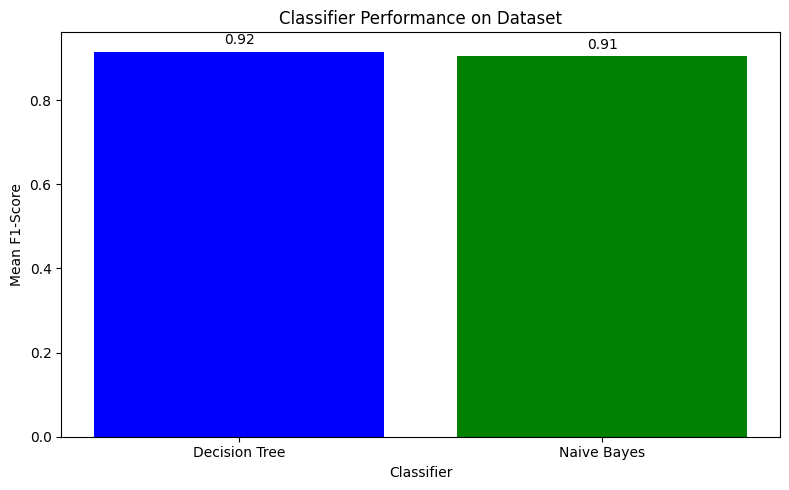

In [71]:
classifiers = ['Decision Tree', 'Naive Bayes']
mean_f1_scores = [dt_mean_f1, nb_mean_f1] 

# bar chart
plt.figure(figsize=(8, 5))
plt.bar(classifiers, mean_f1_scores, color=['blue', 'green'])

# titles and labels
plt.title('Classifier Performance on Dataset')
plt.xlabel('Classifier')
plt.ylabel('Mean F1-Score')

# value labels on top of each bar 
for i, score in enumerate(mean_f1_scores):
    plt.text(i, score + 0.01, f'{score:.2f}', ha='center', va='bottom')

# plot
plt.tight_layout()
plt.show()


## Q2 - Dimensionality reduction with the Singular Value Decomposition

#### SVD Implementation & Plotting

#### Steps followed:
1. Implemented SVD to reduce dimentionality of the feature spaace, evaluating performance with different ranks.
2. Used stratified 10-fold cross-validation on each rank to assess the classifier's performance, obtaining mean F1 scores.
3. Generated a line plot of F1 scores as a function of SVD rank for both classifiers, illustrating how dimensionality affects performance.

In [ ]:
def apply_svd(X_train, X_test, n_components):
    """
    Apply SVD to the training data and transform the test data accordingly.

    Params:
        X_train: Training feature matrix.
        X_test: Test feature matrix.
        n_components: Number of components to keep.
    Returns: 
        Transformed training and test matrices.
    """
    svd = TruncatedSVD(n_components=n_components)
    X_train_svd = svd.fit_transform(X_train)
    X_test_svd = svd.transform(X_test)
    return X_train_svd, X_test_svd

def evaluate_with_svd(clf, X, y, ranks):
    """
    Evaluate classifier performance using SVD for dimensionality reduction.
    Params:
        clf: Classifier object.
        X: Feature matrix.
        y: Target labels.
        ranks: List of SVD ranks to evaluate.
    Returns:
        List of mean F1 scores corresponding to each rank.
    """
    skf = StratifiedKFold(n_splits=10)
    performance_scores = []

    for rank in ranks:
        f1_scores = []
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Apply SVD to reduce dimensionality
            X_train_svd, X_test_svd = apply_svd(X_train, X_test, n_components=rank)
            
            # Fit and evaluate the classifier
            clf.fit(X_train_svd, y_train)
            y_pred = clf.predict(X_test_svd)
            f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

        # Store the mean F1 score for this rank
        mean_f1 = np.mean(f1_scores)
        performance_scores.append(mean_f1)
    
    return performance_scores

In [73]:
# Load your dataset (ensure X and y are numpy arrays)
# X, y = load_your_data()
X = np.array(X)
y = np.array(y)

# Define the classifier (use the ones from Q1)
decision_tree = DecisionTreeClassifier(max_depth=5)
naive_bayes = NaiveBayesClassifier()

In [74]:
# Define the ranks for SVD
ranks = [2, 5, 10, 20, 30]

# Evaluate Decision Tree with SVD
dt_scores = evaluate_with_svd(decision_tree, X, y, ranks)

# Evaluate Naive Bayes with SVD
nb_scores = evaluate_with_svd(naive_bayes, X, y, ranks)

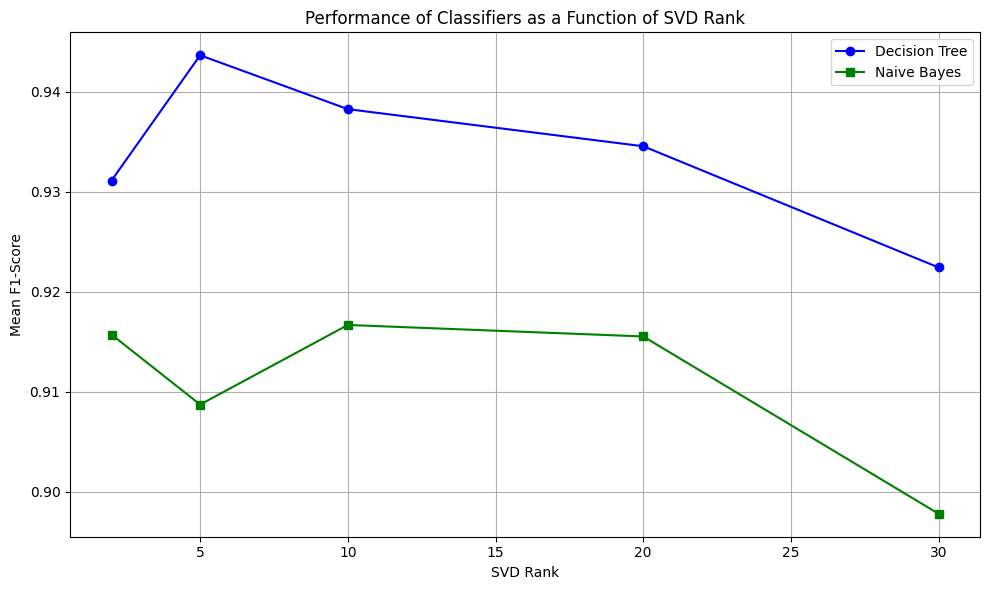

In [76]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(ranks, dt_scores, marker='o', label='Decision Tree', color='blue')
plt.plot(ranks, nb_scores, marker='s', label='Naive Bayes', color='green')

#titles and labels
plt.title('Performance of Classifiers as a Function of SVD Rank')
plt.xlabel('SVD Rank')
plt.ylabel('Mean F1-Score')
plt.legend(loc='best')
plt.grid(True)

# plot
plt.tight_layout()
plt.show()

## Q3 - Feature selection with randomization

#### Steps followed
1. For each feature, created a copy of the dataset with that feature's values randomized to evaluate its importance.
2. Used 5-fold cross-validation to compare model performance on the original dataset versus the randomized dataset for each feature, calculating the F1 score drop as a measure of feature importance.
3. Ranked features by their importance and plotted a bar chart of feature importance scores for both classifiers.

In [ ]:

# Function to randomize a feature
def randomize_feature(X, feature_idx):
    """
    Randomize the values of a specifed feature column

    Params:
        X (ndarray): feature matrix
        feature_idx (int): Index of the feature to randomize

    Returns:
        X_randomize: feature matrix with the specified feature randomized.
    """
    X_randomized = X.copy()
    X_randomized[:, feature_idx] = np.random.permutation(X_randomized[:, feature_idx])
    return X_randomized

# Function to evaluate the impact of randomizing a feature
def evaluate_randomized_feature(X, y, feature_idx, clf):
    """
    Evaluates the impact of randomizing a single feature by comparing the classifier's performance 
    with original and randomized feature values.
    
    Params:
        X (ndarray): Feature matrix.
        y (ndarray): Labels array.
        feature_idx (int): Index of the feature to randomize.
        clf (classifier object): The classifier to evaluate (must have fit and predict methods).
    
    Returns:
        importance_score (float): Difference in mean F1-score between original and randomized feature,
                                  indicating the feature's importance.
    """
    skf = StratifiedKFold(n_splits=5) # Using 5-fold stratified cross-validation, as its a 20% stratified random sample
    original_scores = []
    randomized_scores = []

    # Loop over each train-test split in cross-validation
    for train_idx, test_idx in skf.split(X, y):
        # Split the data into training and testing sets
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Train and evaluate with original data
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        original_scores.append(f1_score(y_test, y_pred, average='weighted'))

        # Train and evaluate with randomized data
        X_train_randomized = randomize_feature(X_train, feature_idx)
        X_test_randomized = randomize_feature(X_test, feature_idx)
        clf.fit(X_train_randomized, y_train)
        y_pred_randomized = clf.predict(X_test_randomized)
        randomized_scores.append(f1_score(y_test, y_pred_randomized, average='weighted'))
    # Calculate mean F1-scores for original and randomized feature data
    original_mean_f1 = np.mean(original_scores)
    randomized_mean_f1 = np.mean(randomized_scores)
    # Calculate the importance score as the difference in F1-score
    importance_score = original_mean_f1 - randomized_mean_f1
    return importance_score

In [ ]:
# Function to get feature importance for a given classifier
def feature_importance_ranking(X, y, clf):
    """
    Calculates and ranks feature importance for a classifier by evaluating the impact of each feature.

    Params:
        X (ndarray): Feature matrix.
        y (ndarray): Labels array.
        clf (classifier object): Classifier to evaluate (must have fit and predict methods).
    
    Returns:
        feature_importances (list): List of tuples (feature index, importance score), sorted by importance.
    """
    feature_importances = []
    for feature_idx in range(X.shape[1]):
        importance_score = evaluate_randomized_feature(X, y, feature_idx, clf)
        feature_importances.append((feature_idx, importance_score))

    # Sort features by their importance scores
    feature_importances.sort(key=lambda x: x[1], reverse=True)
    return feature_importances

# Split the dataset into 20% for feature selection and 80% for evaluation
X_sample, X_holdout, y_sample, y_holdout = train_test_split(X, y, test_size=0.8, stratify=y, random_state=42)

# Ensure X_sample and y_sample are numpy arrays
X_sample = np.array(X_sample)
y_sample = np.array(y_sample)

# Initialize classifiers
decision_tree = DecisionTreeClassifier(max_depth=5)
naive_bayes = NaiveBayesClassifier()

# Rank features for Decision Tree using the 20% sample
dt_feature_importances = feature_importance_ranking(X_sample, y_sample, decision_tree)
dt_indices = [f[0] for f in dt_feature_importances]
dt_scores = [f[1] for f in dt_feature_importances]

# Rank features for Naive Bayes using the 20% sample
nb_feature_importances = feature_importance_ranking(X_sample, y_sample, naive_bayes)
nb_indices = [f[0] for f in nb_feature_importances]
nb_scores = [f[1] for f in nb_feature_importances]

In [84]:
# Output the feature rankings
print("Decision Tree Feature Importances:")
for idx, score in dt_feature_importances:
    print(f"Feature {idx}: Importance {score}")

print("\nNaive Bayes Feature Importances:")
for idx, score in nb_feature_importances:
    print(f"Feature {idx}: Importance {score}")

# Train the classifiers on the 20% sample and evaluate on the 80% holdout data
decision_tree.fit(X_sample, y_sample)
y_dt_pred = decision_tree.predict(X_holdout)
dt_f1 = f1_score(y_holdout, y_dt_pred, average='weighted')

naive_bayes.fit(X_sample, y_sample)
y_nb_pred = naive_bayes.predict(X_holdout)
nb_f1 = f1_score(y_holdout, y_nb_pred, average='weighted')

# Print the final performance on the holdout set
print(f"\nDecision Tree F1 Score on Holdout Data: {dt_f1}")
print(f"Naive Bayes F1 Score on Holdout Data: {nb_f1}")

Decision Tree Feature Importances:
Feature 3: Importance 0.018181818181818077
Feature 6: Importance 0.018181818181818077
Feature 25: Importance 0.018181818181818077
Feature 20: Importance 0.017560217560217528
Feature 24: Importance 0.017560217560217528
Feature 22: Importance 0.009529780564263346
Feature 21: Importance 0.008730284208545047
Feature 5: Importance 0.00832300936366559
Feature 2: Importance 0.0006926406926406337
Feature 23: Importance 0.00041565669927956517
Feature 1: Importance 0.0
Feature 8: Importance 0.0
Feature 9: Importance 0.0
Feature 10: Importance 0.0
Feature 11: Importance 0.0
Feature 12: Importance 0.0
Feature 13: Importance 0.0
Feature 14: Importance 0.0
Feature 15: Importance 0.0
Feature 16: Importance 0.0
Feature 17: Importance 0.0
Feature 18: Importance 0.0
Feature 26: Importance 0.0
Feature 28: Importance 0.0
Feature 29: Importance 0.0
Feature 4: Importance -0.0001767981131239882
Feature 19: Importance -0.00031080031080021886
Feature 0: Importance -0.00814466

/tmp/ipykernel_10279/2887515866.py:31: RuntimeWarning: divide by zero encountered in log
  likelihood = np.sum(np.log(self.gaussian_pdf(x, stats['mean'], stats['var'])))


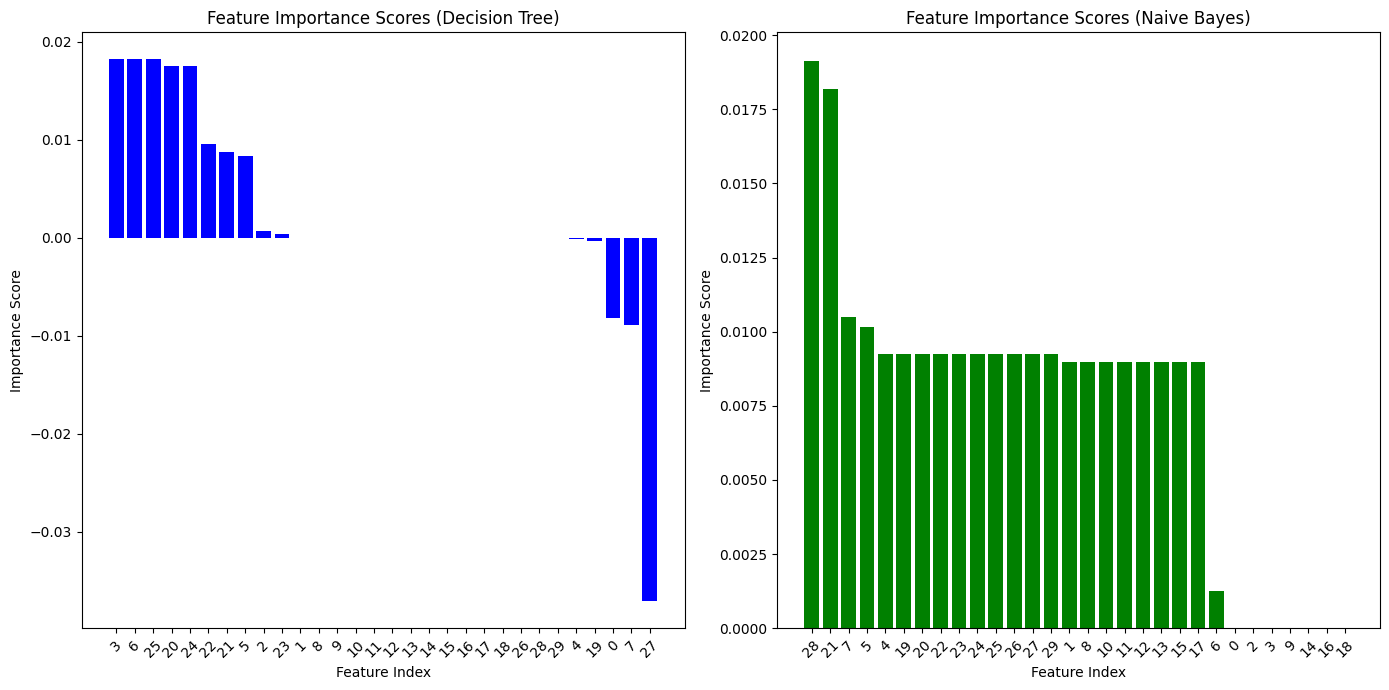

In [86]:
# Plot the feature importance scores for both classifiers
plt.figure(figsize=(14, 7))

# Decision Tree Feature Importance
plt.subplot(1, 2, 1)
plt.bar(range(len(dt_indices)), dt_scores, tick_label=dt_indices, color='blue')
plt.xlabel('Feature Index')
plt.ylabel('Importance Score')
plt.title('Feature Importance Scores (Decision Tree)')
plt.xticks(rotation=45)

# Naive Bayes Feature Importance
plt.subplot(1, 2, 2)
plt.bar(range(len(nb_indices)), nb_scores, tick_label=nb_indices, color='green')
plt.xlabel('Feature Index')
plt.ylabel('Importance Score')
plt.title('Feature Importance Scores (Naive Bayes)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## Q4 - Data augmentation using SMOTE

## Implement SMOTE

#### Steps followed:
1. Implemented SMOTE from scratch to generate synthetic samples for the minority class, based on a specified number of nearest neighbors.
2. valuated classifier performance with SMOTE applied at different oversampling ratios (100%, 200%, 300%) and k values (1, 5) using 5-fold cross-validation, calculating the mean F1 score for each configuration.
3. Plotted F1 scores against the oversampling ratios for each k value, showing the effect of SMOTE on model performance for both classifiers.

In [ ]:
# Function for SMOTE
def smote(X, y, minority_class=1, k=5, oversample_ratio=1.0):
    """
    Generates synthetic samples for the minority class using the SMOTE algorithm.

    Params:
        X (ndarray): Feature matrix.
        y (ndarray): Labels array.
        minority_class (int): Label of the minority class to oversample.
        k (int): Number of nearest neighbors to use for generating synthetic samples.
        oversample_ratio (float): Ratio by which to oversample the minority class.

    Returns:
        X_augmented (ndarray): Augmented feature matrix with synthetic samples.
        y_augmented (ndarray): Augmented labels array with synthetic samples.
    """
    # Separate minority class samples
    X_minority = X[y == minority_class]
    n_minority = len(X_minority)
    n_synthetic = int(n_minority * oversample_ratio)

    # Fit a nearest neighbors model to minority samples
    nbrs = NearestNeighbors(n_neighbors=k + 1).fit(X_minority)
    synthetic_samples = []

    for _ in range(n_synthetic):
        # Randomly select a minority sample
        idx = np.random.randint(0, n_minority)
        x_i = X_minority[idx]

        # Find its k nearest neighbors (excluding itself)
        neighbors = nbrs.kneighbors([x_i], return_distance=False).flatten()[1:]
        neighbor_idx = np.random.choice(neighbors)
        x_neighbor = X_minority[neighbor_idx]

        # Generate a synthetic sample between x_i and the chosen neighbor
        gap = np.random.rand()
        synthetic_sample = x_i + gap * (x_neighbor - x_i)
        synthetic_samples.append(synthetic_sample)

    # Add synthetic samples to the minority class
    # convert synthetic sample list to array
    X_synthetic = np.array(synthetic_samples)
    y_synthetic = np.full(X_synthetic.shape[0], minority_class)
    # append synthetic samples to the original dataset
    X_augmented = np.vstack([X, X_synthetic]) # Add synthetic samples to feature matrix
    y_augmented = np.hstack([y, y_synthetic]) # Add synthetic labels to label array

    return X_augmented, y_augmented


## Evaluate Classifiers with Different SMOTE Levels

In [ ]:
# Function to evaluate classifiers with different levels of SMOTE oversampling
def evaluate_smote(X, y, clf, k_values, oversample_ratios, minority_class=1):
    """
    Evaluates classifier performance with varying SMOTE oversampling parameters.

    Params:
        X (ndarray): Feature matrix.
        y (ndarray): Labels array.
        clf (classifier object): The classifier to be evaluated.
        k_values (list of int): List of 'k' values for nearest neighbors in SMOTE.
        oversample_ratios (list of float): List of SMOTE oversampling ratios.
        minority_class (int): Label of the minority class to oversample.

    Returns:
        performance_results (dict): Nested dictionary with F1 scores for each (k, oversample_ratio) combination.
    """
    skf = StratifiedKFold(n_splits=5)
    performance_results = {k: {ratio: [] for ratio in oversample_ratios} for k in k_values}

    for k in k_values:
        for oversample_ratio in oversample_ratios:
            f1_scores = []
            for train_idx, test_idx in skf.split(X, y):
                X_train, X_test = X[train_idx], X[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]

                # Apply SMOTE to the training set
                X_train_smote, y_train_smote = smote(X_train, y_train, minority_class, k=k, oversample_ratio=oversample_ratio)

                # Train and evaluate the classifier
                clf.fit(X_train_smote, y_train_smote)
                y_pred = clf.predict(X_test)
                f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

            # Store the mean F1 score for this setting
            mean_f1_score = np.mean(f1_scores)
            performance_results[k][oversample_ratio].append(mean_f1_score)

    return performance_results

## Plot the Performance

In [ ]:
def plot_smote_performance(performance_results, classifier_name):
    """
    Plots the F1 score performance of a classifier across different SMOTE oversampling ratios and k values.

    Params:
        performance_results (dict): Nested dictionary with F1 scores for each (k, oversample_ratio) combination.
        classifier_name (str): Name of the classifier for labeling in the plot.
    """
    plt.figure(figsize=(10, 6))

    # Loop through each k value in the performance results
    for k, results in performance_results.items():
        oversample_ratios = list(results.keys())
        mean_f1_scores = [np.mean(results[ratio]) for ratio in oversample_ratios]
        plt.plot(oversample_ratios, mean_f1_scores, label=f'{classifier_name}, k={k}')

    # Label the axes and title
    plt.xlabel('Oversampling Ratio (%)')
    plt.ylabel('F1 Score')
    plt.title(f'Performance of {classifier_name} with SMOTE')
    plt.legend()
    plt.grid(True)
    plt.show()

## Run Evaluation for Both Classifiers

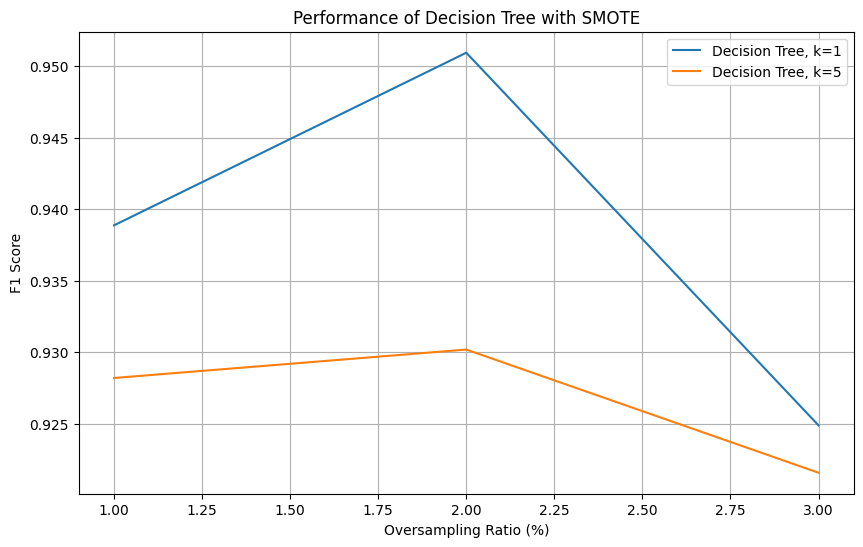

/tmp/ipykernel_10279/2887515866.py:31: RuntimeWarning: divide by zero encountered in log
  likelihood = np.sum(np.log(self.gaussian_pdf(x, stats['mean'], stats['var'])))
/tmp/ipykernel_10279/2887515866.py:31: RuntimeWarning: divide by zero encountered in log
  likelihood = np.sum(np.log(self.gaussian_pdf(x, stats['mean'], stats['var'])))
/tmp/ipykernel_10279/2887515866.py:31: RuntimeWarning: divide by zero encountered in log
  likelihood = np.sum(np.log(self.gaussian_pdf(x, stats['mean'], stats['var'])))
/tmp/ipykernel_10279/2887515866.py:31: RuntimeWarning: divide by zero encountered in log
  likelihood = np.sum(np.log(self.gaussian_pdf(x, stats['mean'], stats['var'])))
/tmp/ipykernel_10279/2887515866.py:31: RuntimeWarning: divide by zero encountered in log
  likelihood = np.sum(np.log(self.gaussian_pdf(x, stats['mean'], stats['var'])))
/tmp/ipykernel_10279/2887515866.py:31: RuntimeWarning: divide by zero encountered in log
  likelihood = np.sum(np.log(self.gaussian_pdf(x, stats['mean

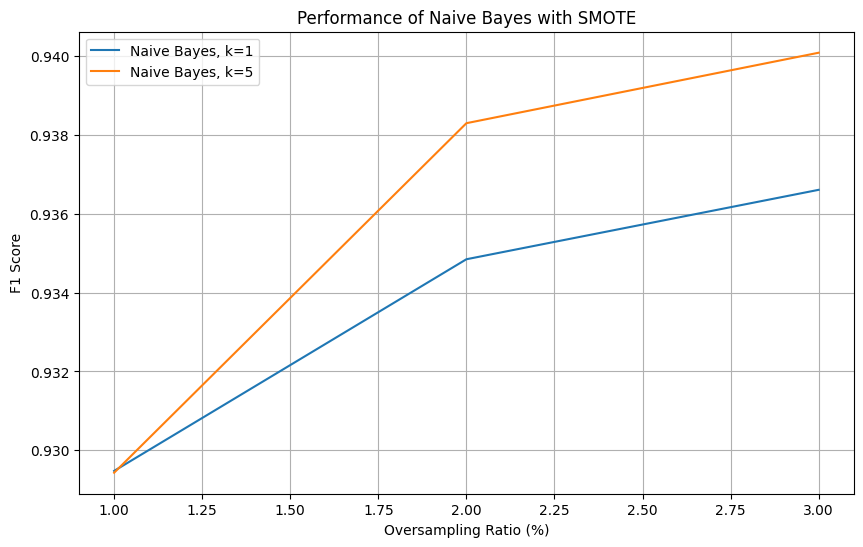

In [91]:
# Convert X and y to numpy arrays if they are not already
X = np.array(X)
y = np.array(y)

# Define oversample ratios (100%, 200%, 300%) and k values (1, 5)
oversample_ratios = [1.0, 2.0, 3.0]  # 100%, 200%, 300%
k_values = [1, 5]

# Initialize classifiers
decision_tree = DecisionTreeClassifier(max_depth=5)
naive_bayes = NaiveBayesClassifier()

# Evaluate Decision Tree
dt_results = evaluate_smote(X, y, decision_tree, k_values, oversample_ratios)
plot_smote_performance(dt_results, 'Decision Tree')

# Evaluate Naive Bayes
nb_results = evaluate_smote(X, y, naive_bayes, k_values, oversample_ratios)
plot_smote_performance(nb_results, 'Naive Bayes')

## References

### Q1

**Decision Tree Classifier**
- https://www.kaggle.com/code/fareselmenshawii/decision-tree-from-scratch
- https://medium.com/@enozeren/building-a-decision-tree-from-scratch-324b9a5ed836

**Naive Bayes**
- https://github.com/gbroques/naive-bayes/blob/master/naive_bayes/naive_bayes.py

### Q2

**SVD**
- https://www.accel.ai/anthology/2022/8/17/svd-algorithm-tutorial-in-python

### Q3

- https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/


### Q4

- https://www.youtube.com/watch?v=oJvjRnuoqQM
- https://medium.com/@corymaklin/synthetic-minority-over-sampling-technique-smote-7d419696b88c